# Import Libraries

In [1]:
import numpy as np                                                       # Numerical Operations 
import pandas as pd                                                      # Data Manipulation
from pathlib import Path                                                 # Data Pathing
import matplotlib.pyplot as plt                                          # Data Visualization
import seaborn as sns                                                    # Data Visualization 
from sklearn.model_selection import train_test_split                     # Data Separation
import tensorflow as tf                                                  # Machine Learning, Deep Learning, CNN
from tensorflow.keras.preprocessing import image                         # Image Operations
from keras.preprocessing import image                                    # Image Operations
from sklearn.metrics import confusion_matrix, classification_report      # Model Evaluation
from sklearn.metrics import accuracy_score                               # Model Evaluation 
import os
import os.path                                                           # String Words Seperation
from pathlib import Path                                                 # File and Folder Paths
from termcolor import colored                                            # Colored print
from tensorflow.keras.applications import VGG16                          # Transfer Learning
from tensorflow.keras.models import Model                                # Deep Learning
from tensorflow.keras.models import load_model                           # Deep Learning
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input # Deep Learning Operations
from keras.preprocessing import image

import sys
import warnings                                                          # Ignore Unnecessary Error Notifications
if not sys.warnoptions:                             
    warnings.simplefilter("ignore")

# Import Dataset 

In [ ]:
image_dir = Path(r'D:\projects\dataset-mask-detector')

<p>
    Utilizing <a href="https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset" target="_blank">this dataset</a>, I selected the first 500 images of both masked and unmasked faces, totaling 1000 images for my analysis.
</p>

# Create and Train Model

In [2]:
image_dir = Path(r'D:\projects\dataset-mask-detector') 

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

train_df, test_df = train_test_split(image_df, test_size=0.33, shuffle=True, random_state=1)

In [3]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 536 validated image filenames belonging to 2 classes.
Found 134 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
    callbacks=callbacks,
)

results = model.evaluate(test_images, verbose=0)

Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.5507 - loss: 1.6375 - val_accuracy: 0.9627 - val_loss: 0.2199
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.9816 - loss: 0.0959 - val_accuracy: 0.9925 - val_loss: 0.1186


# Test of Maskeds

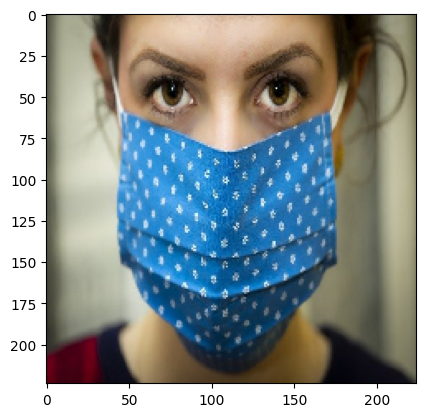

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
[[0.10427292]]
UNMASKED


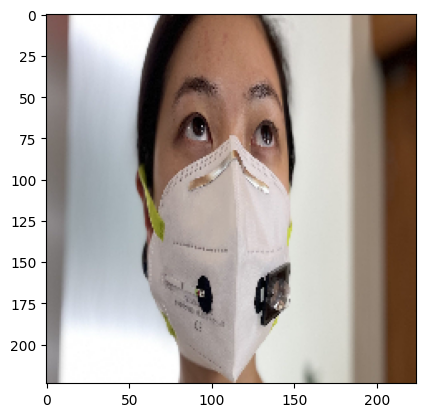

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[[0.9885584]]
MASKED


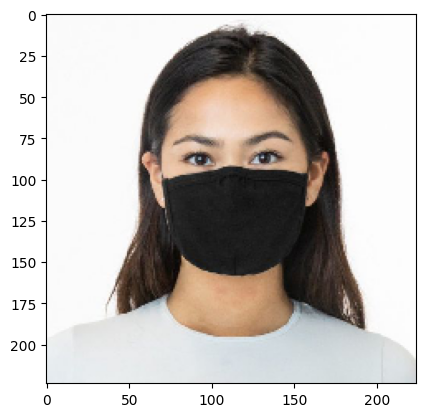

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[0.99999845]]
MASKED


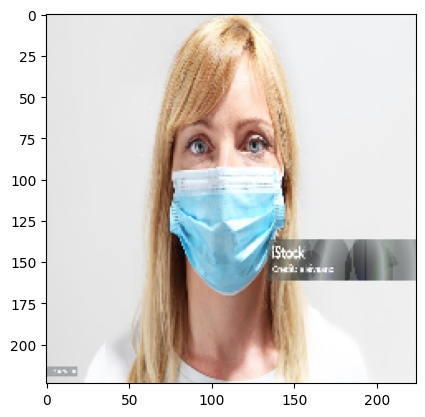

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
[[0.9389169]]
MASKED


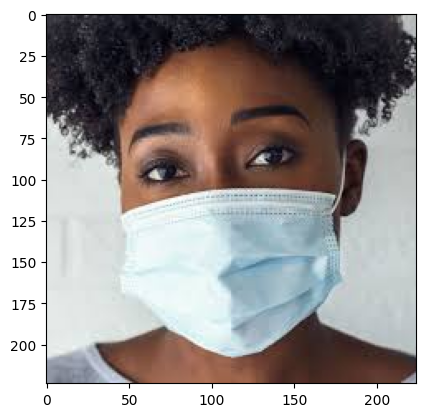

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
[[0.99999845]]
MASKED


In [ ]:
base_img_path = r'D:\projects\dataset-mask-detector\test-images\with_mask\wm_{}.png'

for i in range(1, 6):
    img_path = base_img_path.format(i)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    predictions = model.predict(img_array)
    print(predictions)
    if predictions[0][0] > 0.5:
        print(colored("MASKED", "green"))
    else:
        print(colored("UNMASKED", "red"))


# Test of Unmaskeds

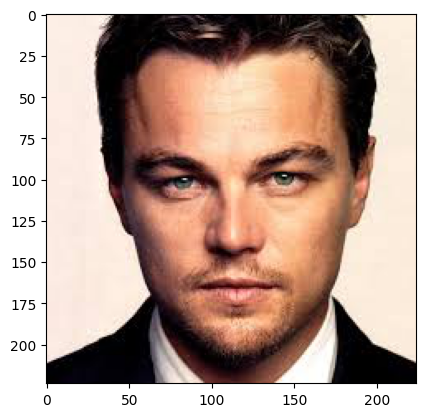

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[[4.2545264e-05]]
UNMASKED


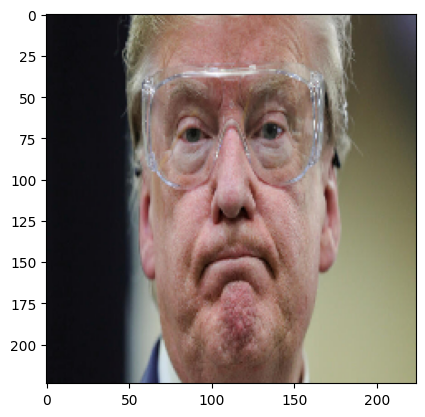

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[8.71569e-05]]
UNMASKED


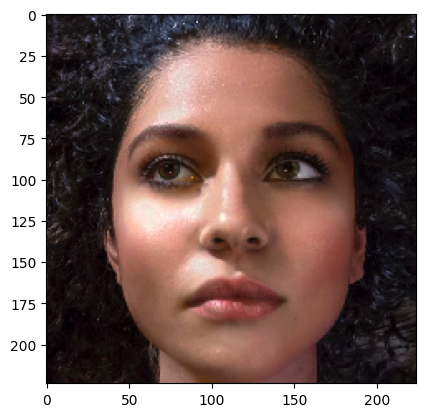

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[[0.00015548]]
UNMASKED


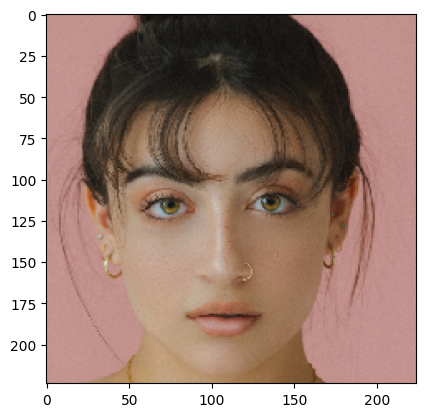

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.0006835]]
UNMASKED


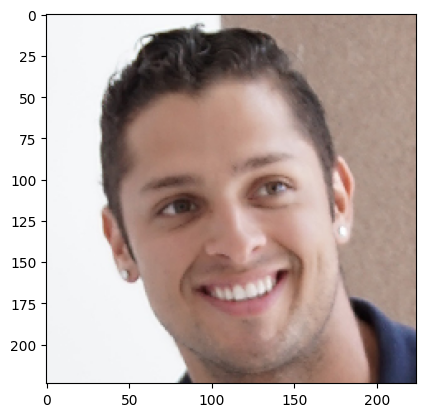

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[[0.00029468]]
UNMASKED


In [7]:
base_img_path = r'D:\projects\dataset-mask-detector\test-images\without_mask\wom_{}.png'

for i in range(1, 6):
    img_path = base_img_path.format(i)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    predictions = model.predict(img_array)
    print(predictions)
    if predictions[0][0] > 0.5:
        print(colored("MASKED", "green"))
    else:
        print(colored("UNMASKED", "red"))


# Save Model

In [8]:
model.save('model.h5')

# Gradio Interface

In [9]:
import gradio as gr
import gradio.themes.base
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from datetime import datetime
from io import BytesIO

In [10]:
# Load Model
model_path = "model.h5"

model = load_model(model_path)

In [11]:
# Preprocesses the image into the format the model expects
def preprocess_image(image, target_size):
    image = Image.fromarray(image).convert('RGB')  # convert from numpy array to PIL image
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

def predict(image):
    # Null Input Control
    result_error_path = os.path.join("07_result_error.png")
    result_error = Image.open(result_error_path)
    if image is None:
        return result_error_image

    try:
        # Preprocess the image
        image = preprocess_image(image, target_size=(224, 224))

        # Make a predict
        prediction = model.predict(image)

        # Load Result Images
        result_masked = Image.open("08_result_masked.png")
        result_unmasked = Image.open("09_result_unmasked.png")

        # Return the result (output) according the prediction
        if prediction.tolist() == [[1.0]]:
            return result_masked
        elif image is None:
            return result_error
        elif prediction.tolist() == [[0.0]]:
            return result_unmasked
        else:
            raise ValueError("Unknown predicted value!")

    except Exception as e:
        return f"<span style='color: black; background-color: yellow; font-size: 10px;'>Error: {str(e)}</span>"

In [25]:
# Gradio Interface Elements
# title
my_title1 = '<span style="font-size: 5rem; font-weight: bold; color: white; background-color: #081b29; display: inline;">Maske </span>'
my_title2 = '<span style="font-size: 5rem; font-weight: bold; color: #00abf0; background-color: #081b29; display: inline;">Dedektörü</span>'
my_title = my_title1 + my_title2

# description
my_description1 = '<span style="font-size: 112.5%; font-weight: 600; color: #ededed;">Maske Dedektörü bir insanın yüzünde maske olup olmadığını algılar. </span>'
my_description2 = '<span style="font-size: 112.5%; font-weight: 600; color: #ededed;">Kullanmak için önce aşağıdan </span>'
my_description3 = '<span style="font-size: 112.5%; font-weight: 600; color: #00abf0;">görüntü yükleyin </span>'
my_description4 = '<span style="font-size: 112.5%; font-weight: 600; color: #ededed;">ardından </span>'
my_description5 = '<span style="font-size: 112.5%; font-weight: 600; color: #00abf0;">Submit butonuna tıklayın</span>'
my_description6 = '<span style="font-size: 112.5%; font-weight: 600; color: #ededed;">.</span>'
my_description = my_description1 + my_description2 + my_description3 + my_description4 + my_description5 + my_description6

# Gradio Interface Example Images
examples = [
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\01_ex_masked1.png"],
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\02_ex_masked2.jpg"],
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\03_ex_masked3.jpg"],
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\04_ex_unmasked1.png"],
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\05_ex_unmasked2.jpg"],
    [r"C:\Users\Soner Kar\Desktop\mask-detector\images\images\06_ex_unmasked3.png"],
]

In [26]:
# Gradio Interface
my_interface = gr.Interface(
    fn=predict, 
    inputs=gr.Image(type="numpy", label="Görsel Yükle"),
    outputs=gr.Image(type="numpy", label="Sonuç"), 
    title=my_title, 
    description=my_description,
    examples=examples,
    live=False,
    theme=gr.themes.Default().set(
        button_primary_background_fill="#FF0000",
        button_primary_background_fill_hover="#FF0000",
        button_secondary_background_fill="green",
        button_secondary_background_fill_hover="green",
    ),
    css=r"C:\Users\Soner Kar\Desktop\mask-detector\styles.css",
)

my_interface.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
